In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from autoplan.neighbors import TreeNNClassifier, NNClassifier
from autoplan.token import OCamlTokenizer, PyretTokenizer, TokenType
from autoplan.trainer import ClassifierTrainer
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.dataset import TrainVal, RandomSplit, concat_datasets, set_random_seed
from grammars.rainfall.ocaml import Labels
import dataclasses
import torch
from tqdm.auto import tqdm
from torch import nn
from torch.utils.data import Subset
import numpy as np
from scripts.rainfall_ingest import ingest_dataset, load_full_t1
import pandas as pd
from pickle_cache import PickleCache
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.spatial import distance 

pcache = PickleCache()
device = torch.device('cuda:7')

In [19]:
datasets = {
    'T1': load_full_t1(),
    'T1Acc': ingest_dataset('T1Acc')
}

Skipped 16 programs
Skipped 2 programs


In [29]:
datasets['T1'].label_set

[<GeneralRainfallLabels.CleanFirst: 0>,
 <GeneralRainfallLabels.CleanInSC: 1>,
 <GeneralRainfallLabels.SingleLoop: 2>]

In [48]:
c = pd.Series([t['labels'].item() for t in datasets['T1'].dataset]).value_counts().sort_index()
list(zip([str(l) for l in datasets['T1'].label_set], (c / c.sum()).tolist()))

[('GeneralRainfallLabels.CleanFirst', 0.4411764705882353),
 ('GeneralRainfallLabels.CleanInSC', 0.19852941176470587),
 ('GeneralRainfallLabels.SingleLoop', 0.3602941176470588)]

In [50]:
c = pd.Series([t['labels'].item() for t in datasets['T1Acc'].dataset]).value_counts().sort_index()
list(zip([str(l) for l in datasets['T1Acc'].label_set], (c / c.sum()).tolist()))

[('GeneralRainfallLabels.CleanFirst', 0.47619047619047616),
 ('GeneralRainfallLabels.CleanInSC', 0.21428571428571427),
 ('GeneralRainfallLabels.SingleLoop', 0.30952380952380953)]

In [51]:
model_opts = {
    'model': nn.LSTM,
    'hidden_size': 512,
    'embedding_size': 128
}

val_frac = 0.33

In [52]:
def rnn_eval(ds):
    set_random_seed(0)
    return ClassifierTrainer.crossval(
        ds, split=RandomSplit(ds), k=30, epochs=100, val_frac=val_frac, 
        model_opts=model_opts, device=device)

rnn_eval = {
    k: rnn_eval(datasets[k])
    for k in ['T1', 'T1Acc']
}

In [53]:
def plot_confusion_distribution(evals, hist=False):
    cms = [evl.confusion_matrix for evl in evals]
    
    bad = set([])
    for k, cm in enumerate(cms):
        for i in range(3):
            if np.sum(cm[i, :]) == 0:
                bad.add((i, k))
    
    cms_np = np.nan_to_num(np.concatenate([
        np.expand_dims(cm / cm.sum(axis=1)[:,np.newaxis], axis=2) for cm in cms
    ], axis=2))
    
    ls = datasets['T1'].label_set
    df = []
    for i, ltrue in enumerate(ls):
        for j, lpred in enumerate(ls):
            row = cms_np[int(ltrue), int(lpred), :]
            
            # For graphs with all zeros, add a bit of noise so it shows up on the plot
            if np.sum(row) < 0.0001:
                row += np.random.rand(*row.shape) * 0.03
                
            for k, c in enumerate(row):
                if (i, k) in bad:
                    continue
                df.append({
                    'True': str(ltrue).split('.')[1],
                    'Pred': str(lpred).split('.')[1],
                    'Count': c
                })
                
    df = pd.DataFrame(df)
    
    g = sns.FacetGrid(df, row='True', col='Pred', height=1.8, aspect=1.5)
    if hist:
        g.map(plt.hist, 'Count', bins=np.arange(0, 1, 0.1))
    else:
        g.map(sns.kdeplot, 'Count', shade=True, clip=(0, 10))

    g.set_titles('')
    g.set(xlim=[0, 1], ylim=[0, 10])

    labels = ['Clean First', 'Clean Multiple', 'Single Loop']
    for i in range(3):
        g.facet_axis(i, 0).set_ylabel(labels[i])
        g.facet_axis(2, i).set_xlabel(labels[i])

    g.facet_axis(1, 0).annotate(
        'True plan', (-0.4, 0.5), (0, 0), xycoords='axes fraction', textcoords='offset points', va='center', ha='center', rotation='vertical')
    g.facet_axis(2, 1).annotate(
        'Predicted plan', (0.5, -0.4), (0, 0), xycoords='axes fraction', textcoords='offset points', va='top', ha='center')
    g.fig.subplots_adjust(wspace=.2, hspace=.12)
    #plt.tight_layout()

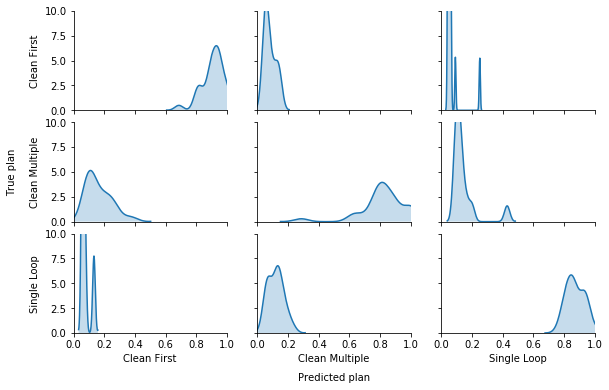

In [54]:
rnn_max_eval = [
    val_eval[np.argmax([evl.accuracy for evl in val_eval])]
    for val_eval in rnn_eval['T1']['val_eval']
]
plot_confusion_distribution(rnn_max_eval)
plt.savefig('error-rnn-ocaml.pdf', bbox_inches='tight')

In [55]:
def make_cls(ds, tok):
    cls = TreeNNClassifier(ds, tok)
    return (cls, cls.compute_distance_matrix(cls.programs))

nn_cls = {
    'T1': pcache.get('nn_ocaml', lambda: make_cls(datasets['T1'], OCamlTokenizer())),
    'T1Acc': pcache.get('pyret_nn', lambda: make_cls(datasets['T1Acc'], PyretTokenizer()))
}

In [56]:
set_random_seed(0)
def nn_eval(cls, dist):
    return cls.crossval(dist, folds=30, val_frac=0.1)

nn_eval = {
    k: nn_eval(*nn_cls[k])
    for k in ['T1', 'T1Acc']
}

In [60]:
plot_confusion_distribution(nn_eval['T1'])
plt.savefig('error-knn-ocaml.pdf')

AttributeError: 'list' object has no attribute 'confusion_matrix'

In [61]:
dsname = 'T1'
cls, dist = nn_cls[dsname]
evls, close, val = nn_eval[dsname]
k = 15
evl = evls[k]
for i in evl.incorrect():
    print(i)
    print('Pred:', str(Labels(evl.pred[i])))
    print('True:', str(Labels(evl.true[i])))
    print()
    print(cls.dataset.dataset[close[k][i][0]]['source'])
    print('='*30)
    print(cls.dataset.dataset[val[k][i]]['source'])
    print('\n\n\n')

4
Pred: GeneralRainfallLabels.SingleLoop
True: GeneralRainfallLabels.CleanFirst

let rainfall (aloi : int list) =
  (let rec rainfall_helper (aloi : int list) (accumulator : int)
     (counter : int) =
     (match aloi with
      | [] ->
          if counter = 0
          then failwith "chico...que esta haciendo?!"
          else accumulator / counter
      | head::tail ->
          (match head with
           | (-999) ->
               if counter = 0
               then failwith "chico...que esta haciendo?!"
               else accumulator / counter
           | _ ->
               if head >= 0
               then rainfall_helper tail (accumulator + head) (counter + 1)
               else rainfall_helper tail accumulator counter) : int) in
   rainfall_helper aloi 0 0 : int)

let rainfall (alon : int list) =
  (let rec rain_helper (alon : int list) (counter : int) (sum : int) =
     (match alon with
      | [] ->
          if counter = 0
          then failwith "No rain was collected"


In [62]:
def compute_embs(cls, loader):
    return torch.cat([
        cls.model.encoder.forward(batch['program'].to(device), batch['program_len'].to(device))
        for batch in loader
    ]).cpu().detach().numpy()

In [63]:
ds = datasets['T1']
def get_embs():
    cls = ClassifierTrainer(dataset=ds, split=RandomSplit(ds, shuffle=False), device=device, model_opts=model_opts)
    _1, _2, val_eval, state = cls.train(epochs=100)
    i = np.argmax([evl.accuracy for evl in val_eval])
    cls.model.load_state_dict(state[i])

    train_embs = compute_embs(cls, cls.train_loader)
    val_embs = compute_embs(cls, cls.val_loader)
    
    return cls, train_embs, val_embs, val_eval[i]

In [64]:
eq = 0
neq = 0

for _ in range(15):
    train_embs, val_embs, evl  = get_embs()
    incorrect = np.argwhere(evl.pred != evl.true).squeeze()


    for i in incorrect:
        val_emb = val_embs[i]
        closest = np.argmin(np.linalg.norm(train_embs - val_emb, axis=1))
#         print(cls.val_dataset[i]['source'])
#         print(cls.train_dataset[closest]['source'])
#         print('='*30)
        if evl.pred[i] == cls.train_dataset[closest]['labels'].item():
            eq += 1
        else:
            neq += 1

ValueError: too many values to unpack (expected 3)

In [ ]:
from sklearn.manifold import TSNE
cls, train_embs, val_embs, evl = get_embs()

In [ ]:
X = TSNE(n_components=2).fit_transform(np.vstack([train_embs, val_embs])) #[len(train_embs):,:]

#Y = [i['labels'].item() for i in cls.train_dataset] 
Y = [i['labels'].item() for i in cls.val_dataset]

proper_labels = {
    'CleanFirst': 'Clean First',
    'CleanInSC': 'Clean Multiple',
    'SingleLoop': 'Single Loop'
}

df = pd.DataFrame([
    {
        'True label': proper_labels[cls.class_names[item['labels'].item()]], 
        #'Correct?': evl.pred[i] == evl.true[i],
        'Dataset': 'Train',
        't-SNE X1': X[i, 0],
        't-SNE X2': X[i, 1],
    }
    for i, item in enumerate(cls.train_dataset)
] + [
    {
        'True label': proper_labels[cls.class_names[item['labels'].item()]], 
        #'Correct?': evl.pred[i] == evl.true[i],
        'Dataset': 'Test',
        't-SNE X1': X[len(train_embs) + i, 0],
        't-SNE X2': X[len(train_embs) + i, 1],
    }
    for i, item in enumerate(cls.val_dataset)
    if evl.pred[i] != evl.true[i]
])

sns.scatterplot(
    data=df,
    x='t-SNE X1',
    y='t-SNE X2',
    hue='Dataset',
    style='True label',
    legend='full')
sns.despine()
plt.tight_layout()
plt.savefig('tsne.pdf')

# sns.scatterplot(x=X[:, 0], y=X[:, 1], style=Y, 
#                 #hue=Y,
#                 hue=(evl.true != evl.pred).tolist(),
#                 #hue=[0 for _ in cls.train_dataset] + [1 if x else 2 for x in (evl.true != evl.pred).tolist()],
#                 palette=sns.color_palette()[:2])

In [ ]:
len(df[df.Dataset == 'Test'])

In [ ]:
eq / (eq + neq)